In [79]:
from pyiron_workflow import Workflow
import os 
from pathlib import Path
import shutil
import json
import subprocess
import numpy as np

In [80]:
# Setup

# simulation
abq = "/isi/programs/simulia/2023_1/Commands/abaqus"
sim_path = '' # not necessary
job_name = '' # not necessary
eval_script_path = "/home/chri/w/OntOMat/Workflow/OntOMat_Workflow/Scripts/extract_homogenized_stiffness.py"
remove_folder = False # not necessary

# materials
fiber_material_ID = "carbon"
matrix_material_ID = "PA6"

# micro
vol_frac = 0.4
fiber_rad = 0.3
RVE_depth_micro = 0.3
num_rad = 10
num_depth = 5
plugin_path = "/home/chri/w/OntOMat/Workflow/OntOMat_Workflow/Scripts/Abaqus_Plugin/MicroMechanics_v1.18/MicroMechanics"

# homogenized material IDs
micro_ID = "carbon_PA6_UD"
macro_ID = "carbon_PA6_laminate"


In [81]:
RVE_b_micro = np.sqrt(np.pi*fiber_rad**2 / (2*vol_frac*np.tan(30/180*np.pi)))
RVE_h_micro = RVE_b_micro*np.tan(30/180*np.pi)
RVE_volume_micro = 4*RVE_h_micro*RVE_b_micro*RVE_depth_micro

In [82]:
# Generate/Delete Folder

@Workflow.wrap.as_function_node
def generate_sim_folder(sim_path: str = '') -> str:
    """
    Generate simulation folder.

    Parameters
    ----------
    sim_path : str
        Simulation folder path.

    Returns
    -------
    sim_path : str
        Simulation folder path.
    """

    if sim_path == '':
        cwd = os.getcwd()
        sim_path = cwd + '/sim_tmp/'
        
    Path(sim_path).mkdir(parents=True, exist_ok=True)
    
    return sim_path

@Workflow.wrap.as_function_node
def remove_sim_folder(remove: bool = True, sim_path: str = ''):
    """
    Remove simulation folder.

    Parameters
    ----------
    remove : bool
        Flag to remove the folder or not.
    sim_path : str
        Simulation folder path.

    """
    if remove:
        shutil.rmtree(sim_path)
    

In [83]:
# OntOMat Query

@Workflow.wrap.as_function_node
def ontomat_query(fiber_material_ID: str, matrix_material_ID: str, sim_path: str) -> tuple[dict, str]:
    """
    Return material parameters based on a SPARQL query to KG of OntOMat.

    Parameters
    ----------
    fiber_material_ID : str
        Unique ID of fiber material.
    matrix_material_ID : str
        Unique ID of matrix material.

    Returns
    -------
    materials : dict
        Relevant material parameters.
    sim_path : str
        Simulation folder path.
    """

    # For now dummy data

    materials = dict()

    if fiber_material_ID == 'carbon':
        materials['fiber'] = {'name': 'carbon',
                    'symmetry_class': 'isotropic', 'E': 230e3, 'nu': 0.1}
    else:
        raise ValueError('Fiber material not supported.')

    if matrix_material_ID == 'PA6':
        materials['matrix'] = {'name': 'PA6',
                    'symmetry_class': 'isotropic', 'E': 2e3, 'nu': 0.33}
    else:
        raise ValueError('Matrix material not supported.')

    return materials, sim_path

@Workflow.wrap.as_function_node
def ontomat_upload(material_ID: str, material_coefficients: dict):

    # upload
    # stuff
    # to
    # knowledge
    # graph

    print("Uploading to OntOMat knowledge graph...")
    
    return
    

In [84]:
# Pre-Process

@Workflow.wrap.as_function_node
def pre_process_micro(materials: dict, 
                      sim_path: str,
                      plugin_path: str,
                      abq: str,
                      cae_name: str='micro_structure.cae',
                      job_name: str='UD_hex_homogen',
                      vol_frac: float=0.1,
                      fiber_rad: float=0.3,
                      interface_ratio: float=0.0,
                      depth: float=0.3,
                      num_rad: int=10,
                      num_depth: int=5,
                      ) -> tuple[str, str]:


    abaqus_micro_input = dict()

    fiber = dict()
    fiber["volume_content"] = vol_frac
    fiber["radius"] = fiber_rad
    fiber["interface_ratio"] = interface_ratio
    fiber["name"] = materials["fiber"]["name"]
    fiber["symmetry_class"] = materials["fiber"]["symmetry_class"]
    fiber["E"] = materials["fiber"]["E"]
    fiber["nu"] = materials["fiber"]["nu"]

    matrix = dict()
    matrix["name"] = materials["matrix"]["name"]
    matrix["symmetry_class"] = materials["matrix"]["symmetry_class"]
    matrix["E"] = materials["matrix"]["E"]
    matrix["nu"] = materials["matrix"]["nu"]
    
    mesh = dict()
    mesh["num_rad"] = num_rad
    mesh["num_depth"] = num_depth

    geometry = dict()
    geometry["depth"] = depth
    geometry["mesh"] = mesh

    micro = dict()
    micro["fiber"] = fiber
    micro["matrix"] = matrix
    micro["geometry"] = geometry

    simulation = dict()
    simulation["sim_path"] = sim_path 
    simulation["plugin_path"] = plugin_path
    simulation["cae_name"] = cae_name
    simulation["job_name"] = job_name

    abaqus_micro_input = dict()
    abaqus_micro_input["micro"] = micro
    abaqus_micro_input["simulation"] = simulation

    abaqus_micro_input_json = json.dumps(abaqus_micro_input, indent=2, sort_keys=True)
    
    abaqus_json_path = sim_path + 'abaqus_micro.json'
    with open(abaqus_json_path, 'w') as abaqus_json_file:
        abaqus_json_file.write(abaqus_micro_input_json)


    call_command = abq + ' cae noGUI=generate_cae_micro.py -- {}'.format(
            abaqus_json_path)


    print(call_command)

    subprocess.call(call_command, shell=True)

    return sim_path, job_name
    

In [85]:
# Abaqus Runner

@Workflow.wrap.as_function_node
def abaqus_runner(sim_path: str, job_name: str, abaqus_cores: int=1, abaqus_version: str='2023', lic_server: str='lic5') -> tuple[str, str]:

    call_command = "cd {sim_path}; abawrapper -v {abaqus_version} -j {job_name} -cpus {abaqus_cores} -l {lic_server} -inter".format(
        sim_path=sim_path, abaqus_version=abaqus_version, job_name=job_name, abaqus_cores=abaqus_cores, lic_server=lic_server)

    subprocess.call(call_command, shell=True)

    return sim_path, job_name


In [86]:
# Abaqus Evaluator

@Workflow.wrap.as_function_node
def abaqus_evaluator(sim_path: str, job_name: str, abq: str, eval_script_path: str, RVE_volume: float) -> tuple[str, dict]:

    call_command = abq + \
        ' cae noGUI={} -- {} {} {}'.format(eval_script_path,
                                           sim_path, job_name, RVE_volume)

    subprocess.call(call_command, shell=True)

    homogen_json_path = sim_path + job_name + '_homogenized_stiffness_mandel.json'

    with open(homogen_json_path, 'r') as json_file:
        homogen_json = json.load(json_file)

    return sim_path, homogen_json
    


In [87]:
wf = Workflow("micro_simulation")
wf.generate_sim_folder = generate_sim_folder()
wf.ontomat_query = ontomat_query(sim_path=wf.generate_sim_folder.outputs.sim_path)
wf.pre_process_micro = pre_process_micro(materials=wf.ontomat_query.outputs.materials,
                                         sim_path=wf.ontomat_query.outputs.sim_path)
wf.abaqus_runner_micro = abaqus_runner(sim_path=wf.pre_process_micro.outputs.sim_path,
                                      job_name=wf.pre_process_micro.outputs.job_name)
wf.abaqus_evaluator_micro = abaqus_evaluator(sim_path=wf.abaqus_runner_micro.outputs.sim_path,
                                          job_name=wf.abaqus_runner_micro.outputs.job_name)
wf.ontomat_upload_micro = ontomat_upload(material_coefficients=wf.abaqus_evaluator_micro.outputs.homogen_json)
wf.remove_sim_folder = remove_sim_folder(sim_path=wf.generate_sim_folder.outputs.sim_path)


In [88]:
wf(ontomat_query__fiber_material_ID=fiber_material_ID,
   ontomat_query__matrix_material_ID=matrix_material_ID,
   pre_process_micro__plugin_path=plugin_path,
   pre_process_micro__abq=abq,
   pre_process_micro__vol_frac=vol_frac,
   pre_process_micro__fiber_rad=fiber_rad,
   pre_process_micro__depth=RVE_depth_micro,
   pre_process_micro__num_rad=num_rad,
   pre_process_micro__num_depth=num_depth,   
   abaqus_evaluator_micro__abq=abq,
   abaqus_evaluator_micro__eval_script_path=eval_script_path,
   abaqus_evaluator_micro__RVE_volume=RVE_volume_micro,
   ontomat_upload_micro__material_ID=micro_ID,
   remove_sim_folder__remove=remove_folder)

/isi/programs/simulia/2023_1/Commands/abaqus cae noGUI=generate_cae_micro.py -- /isi/w/chri/OntOMat/Workflow/OntOMat_Workflow/Notebooks/sim_tmp/abaqus_micro.json


Abaqus License Manager checked out the following license:
"cae" from Flexnet server lic5
<0 out of 1 licenses remain available>.


Wait for Abaqus job 'UD_hex_homogen' to finish ...
JobID           JobName  Partition    Account  AllocCPUS      State ExitCode 
627935       UD_hex_ho+     abaqus   hpc-user          1  COMPLETED      0:0 


Abaqus License Manager checked out the following license:
"cae" from Flexnet server lic5
<0 out of 1 licenses remain available>.


Uploading to OntOMat knowledge graph...


{'abaqus_evaluator_micro__sim_path': '/isi/w/chri/OntOMat/Workflow/OntOMat_Workflow/Notebooks/sim_tmp/',
 'ontomat_upload_micro__None': None,
 'remove_sim_folder__None': None}

In [89]:
# wf.run()

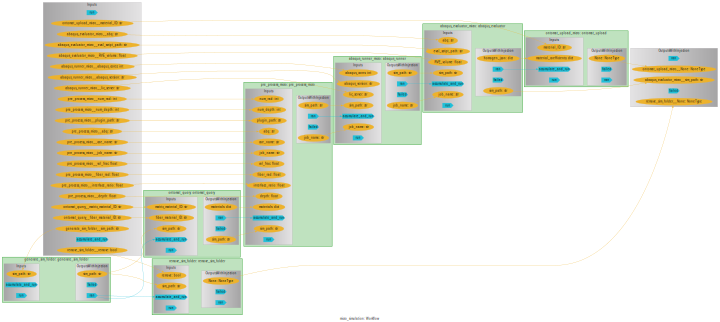

In [90]:
wf.draw(size=(10,10),filename="/isi/w/chri/OntOMat/Workflow/OntOMat_Workflow/Notebooks/WF")